In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib_inline
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
def scatter_plot_(data, col=None):
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s = 0.5, color=col)
    plt.show()

In [4]:
N = 1000
K = 3
d = 3
L = 10

In [5]:
# Generate some data
np.random.seed(42)
mu_true = np.random.uniform(-L, L, size = (K, d))
data = np.random.normal(mu_true, size = (N, K, d))
data = np.vstack(data)
np.random.shuffle(data)

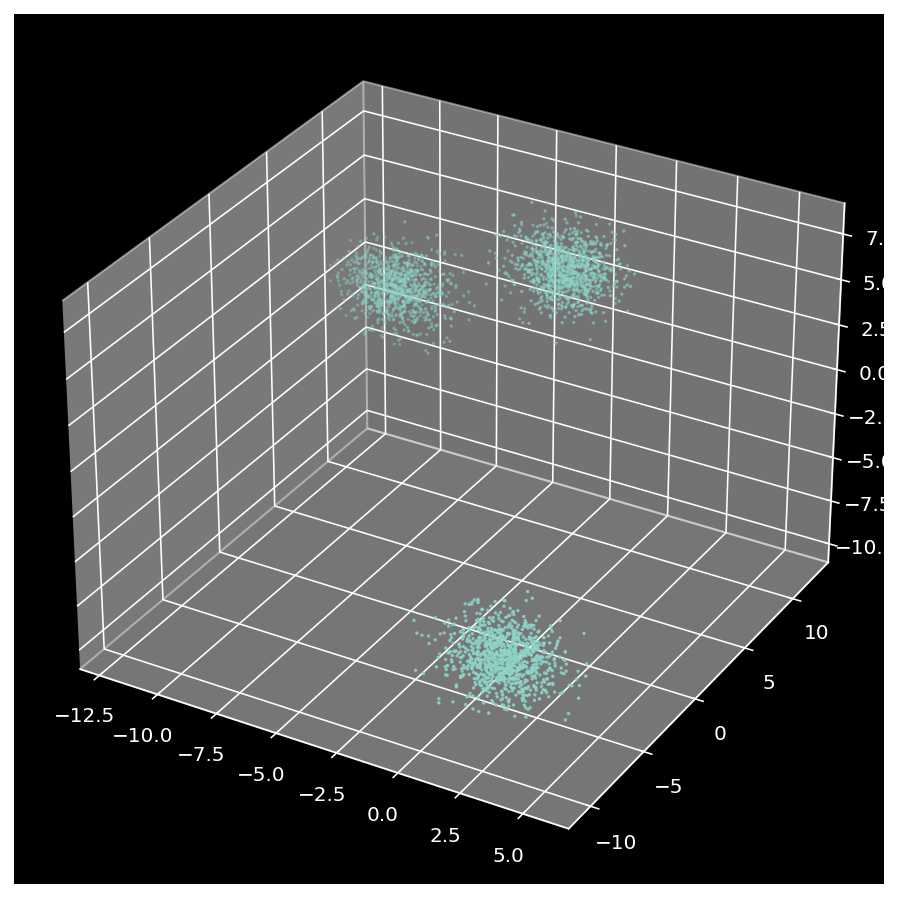

In [6]:
if d == 3:
    scatter_plot_(data, None)

In [7]:
mu = data[np.random.choice(range(data.shape[0]), K, replace=False)]
# c = np.random.randint(low=0, high=K-1, size=data.shape[0])

In [8]:
def dist_i(x, mu):
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        dist[i] = np.sum((x[i] - mu[i])**2)
    return dist

def dist_ij(x, mu):
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    dist = np.zeros((x.shape[0], mu.shape[0]))
    for i in range(x.shape[0]):
        for j in range(mu.shape[0]):
            dist[i, j] += np.sum((x[i] - mu[j])**2)
    return dist

In [9]:
def dist_i_vectorized(x, mu):
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    diff = x - mu
    np.square(diff, out = diff)
    return diff.sum(1)

def dist_ij_vectorized(x, mu):
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    diff = x[:, None] - mu
    np.square(diff, out = diff)
    return diff.sum(-1)

In [10]:
np.isclose(
    dist_i(mu, mu_true),
    dist_i_vectorized(mu, mu_true)
).all()

True

In [11]:
%%timeit
dist_i(mu, mu_true)

6.65 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
%%timeit
dist_i_vectorized(mu, mu_true)

1.29 µs ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [13]:
np.isclose(
    dist_ij(data, mu),
    dist_ij_vectorized(data, mu)
).all()

True

In [14]:
%%timeit
dist_ij(data, mu)

20.1 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
dist_ij_vectorized(data, mu)

184 µs ± 984 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
def k_mean(data, mu):
    ss_list = []
    mu_ = mu.copy()
    for n in range(10):
        c =  np.argmin(dist_ij(data, mu_), axis = 1)    
        ss = np.mean(dist_i(data, mu_[c]))
        ss_list.append(ss)    
        for i in range(K):
            cluster_members = data[c == i]
            cluster_members = cluster_members.mean(axis = 0)
            mu_[i] = cluster_members
    return ss_list, mu_

In [22]:
def k_mean_vectorized(data, mu):
    ss_list = []
    mu_ = mu.copy()
    for n in range(10):
        c =  np.argmin(dist_ij_vectorized(data, mu_), axis = 1)
        ss = np.mean(dist_i_vectorized(data, mu_[c]))
        ss_list.append(ss)
        for i in range(K):
            cluster_members = data[c == i]
            cluster_members = cluster_members.mean(axis = 0)
            mu_[i] = cluster_members
    return ss_list, mu_

In [23]:
%%timeit
k_mean(data, mu)

266 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
k_mean_vectorized(data, mu)

3.61 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
266 / 3.61

73.6842105263158

**Разница в скорости**: 74 раза

In [ ]:
ss_list, mu_ = k_mean_vectorized(data, mu)

In [26]:
colors = np.array([plt.cm.cool(i/(K-1)) for i in range(K)])

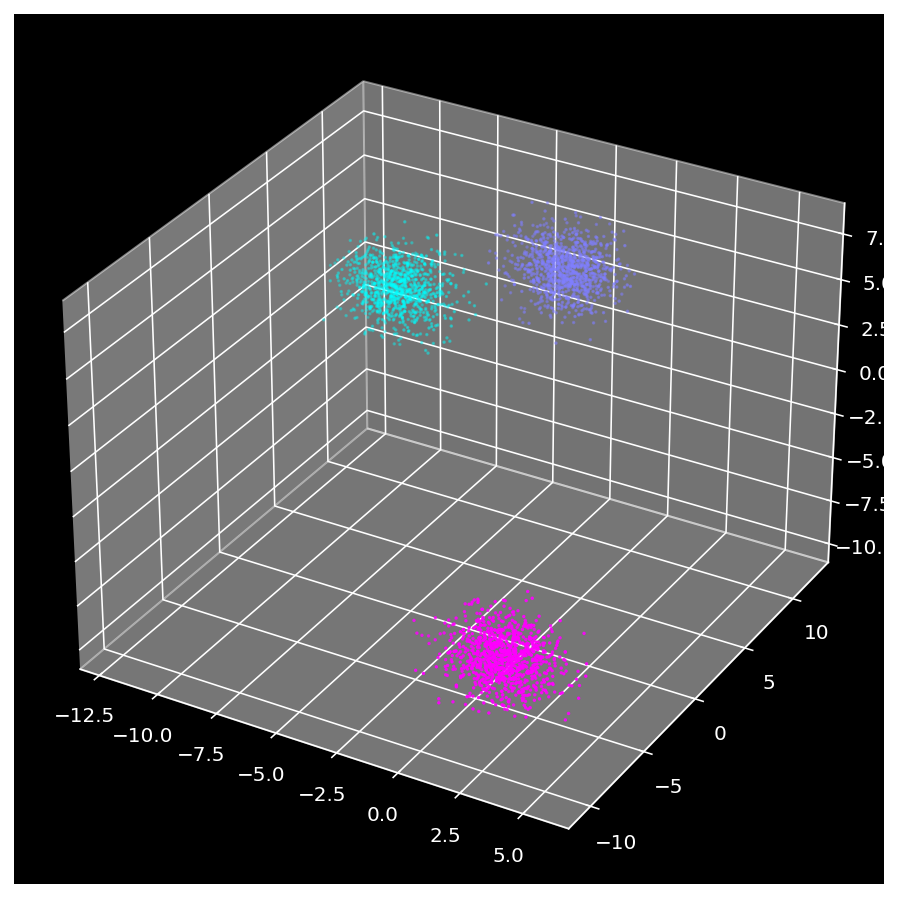

In [27]:
if d == 3:
    scatter_plot_(data, colors[c])

Just for fun, напишем тот же самый код в Julia

In [243]:
N = 1000
K = 3
d = 3
L = 10

10

In [244]:
using Random
Random.seed!(42);

In [245]:
mu_true = 2L * rand(d, K) .- L;

In [246]:
data = randn(d, K, N);
data .+= reshape(mu_true, (d, K, 1));

data = reshape(data, (d, N*K));
data = data[:, randperm(N*K)];

In [247]:
mu = data[:, rand(1:size(data)[2], K)];
#c = rand(rng, 1:K, size(data)[1]);

3×3 Matrix{Float64}:
 -8.15218  -1.10812  -7.17068
  1.01991   6.65042  -0.143022
 -1.07779   3.50337   0.0165063

In [248]:
function dist_i(x, mu)
    # x: N datapoints, mu: N cluster centers
    # returns: D_{i}, squared distances from x[i] to mu[i]
    dist = zeros(size(x)[2])
    for i in eachindex(dist)
        for k in 1 : size(x)[1]
            dist[i] += (x[k, i] - mu[k, i])^2
        end
    end
    return dist
end

function dist_ij(x, mu)
    # x: N datapoints, mu: K cluster centers
    # returns: D_{ij}, squared distances from x[i] to mu[j]
    dist = zeros((size(x)[2], size(mu)[2]))
    for j in 1 : size(mu)[2]
        for i in 1 : size(x)[2]
            for k in 1 : size(mu)[1]
                dist[i,j] += (x[k,i] - mu[k,j])^2
            end
        end
    end
    return dist
end

dist_ij (generic function with 1 method)

In [249]:
using BenchmarkTools

In [250]:
@benchmark dist_ij(data, mu_true)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   93.458 μs …   8.568 ms  ┊ GC (min … max): 0.00% … 98.85%
 Time  (median):      96.625 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   102.277 μs ± 187.230 μs  ┊ GC (mean ± σ):  4.79% ±  2.61%

  ▇▆        ▁▅██▅▄▃▂▂▁▁▁▂▃▃▃▃▃▂▃▃▂▂▂▂▁▁▁▁     ▁▁ ▁▁▁            ▂
  ██▇▅▇▇▅▆▇▇███████████████████████████████████████████▇▆▆▆▄▆▆▄ █
  93.5 μs       Histogram: log(frequency) by time        108 μs <

 Memory estimate: 70.36 KiB, allocs estimate: 2.

In [251]:
function k_mean(data, mu)
    ss_list = zeros(10)
    mu_ = copy(mu)
    c = Array{Int}(undef, size(data)[2])
    for n in 1 : 10
        c .= getindex.(argmin(dist_ij(data, mu_), dims = 2)[:], 2)
        ss = mean(dist_i(data, mu_[:, c]))
        ss_list[n] = ss
        for i in 1 : size(mu)[2]
            cluster_members = data[:, c .== i]
            mu_[:, i] .= mean(cluster_members, dims = 2)
        end
    end
    return ss_list, mu_, c
end

k_mean (generic function with 1 method)

In [252]:
ss_list, mu_, c = k_mean(data, mu);

In [253]:
using Plots

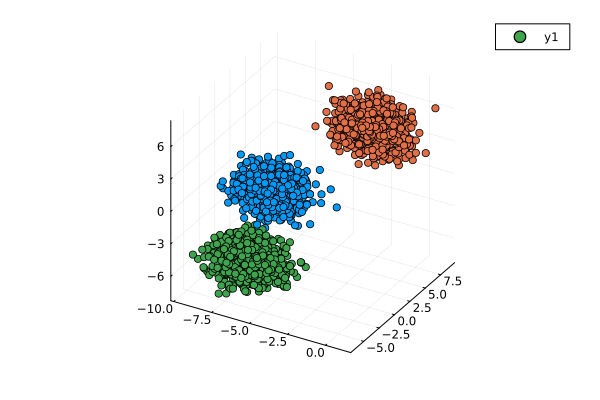

In [254]:
scatter(data[1,:], data[2,:], data[3,:], color = c)

In [256]:
@benchmark k_mean(data, mu)

BenchmarkTools.Trial: 2099 samples with 1 evaluation.
 Range (min … max):  1.980 ms … 11.992 ms  ┊ GC (min … max):  0.00% … 82.68%
 Time  (median):     2.150 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.380 ms ±  1.271 ms  ┊ GC (mean ± σ):  10.14% ± 14.10%

  ▇█▄                                                         
  ███▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▄▁▃▁▅▅▅▃▁▅▃▄▅▆▄▆▃▄▅▃▁▄ █
  1.98 ms      Histogram: log(frequency) by time      9.6 ms <

 Memory estimate: 3.62 MiB, allocs estimate: 654.

In [257]:
# Разница в производительности
3.61 / 2.38

1.5168067226890756

В обоих языках время можно ещё чуть-чуть сократить, если сделать так, чтобы функции `dist_i` и `dist_ij` не создавали временных массивов.